In [43]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import random

from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from shapely.geometry import Polygon, Point
import flexpolyline
import h3

random.seed(1)

data = pd.read_csv('BrasilDataBase.csv').to_dict(orient='index')
print(data[0])

{'RAZAO SOCIAL': 'AIR MATERIAIS PARA CONSTRUCAO LTDA', 'CNPJ': 779000145, 'ENDEREÇO': 'AVENIDA JUCELINO K DE OLIVEIRA  312 , JUQUITIBA', 'lat': -23.9328525, 'lng': -47.0690692, 'CIDADE': 'JUQUITIBA'}


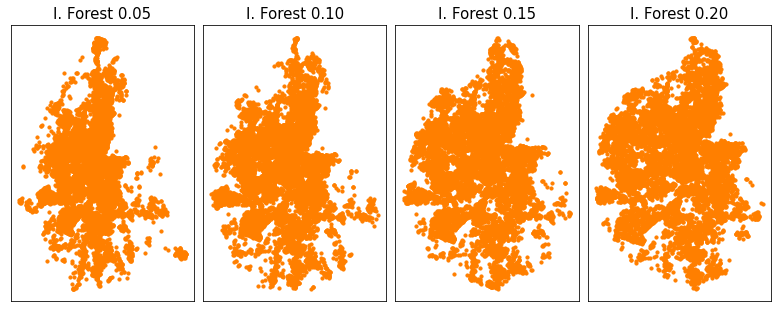

In [44]:
# DataSets
files = ['BrasilDataBase.csv']
datasets = []

for i in files:
    df = pd.read_csv(i)
    df = df.to_dict(orient = 'index')
    datasets.append( np.array([ [df[j]['lat'], df[j]['lng']] for j in df ]) )

# Detection algorithmn with different gamma value
anomaly_algorithms = [
    ("I. Forest 0.05", IsolationForest(contamination=0.05, random_state=42)),
    ("I. Forest 0.10", IsolationForest(contamination=0.10, random_state=42)),
    ("I. Forest 0.15", IsolationForest(contamination=0.15, random_state=42)),
    ("I. Forest 0.20", IsolationForest(contamination=0.20, random_state=42))
]

# Not plotting outliers
plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 4))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
for i_dataset, X in enumerate(datasets):
    for name, algorithm in anomaly_algorithms:
        
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=15)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)
        
        newX = []
        for idx, k in enumerate(y_pred):
            if k == 1:
                newX.append(X[idx])
                
        newX = np.array(newX)
        
        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(newX[:, 0], newX[:, 1], s=10, color=colors[1])
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()

In [45]:
# Se fija el porcentaje de contaminación en 15% y se recorren clusters para determinar cuáles serían las mejores zonas

contamination = 0.05

# Test case - Brasil
df = pd.read_csv('BrasilDataBase.csv')
df = df.to_dict(orient = 'index')

X = []
count = 0
IdK = {}
for j in df:
    X.append([df[j]['lng'], df[j]['lat']])
    IdK[count] = j
    count += 1

X = np.array(X)
outliers_algh = IsolationForest(contamination = contamination) # IsolationForest Algorithm

''' Outliers remover '''
y_pred = outliers_algh.fit(X).predict(X) # Fit algorithm in data
for idx, k in enumerate(y_pred):
    if k == -1:
        df.pop(IdK[idx])

# Point Weight
centerCoors = [-23.546416, -46.633913]
origin = h3.geo_to_h3(centerCoors[0], centerCoors[1], 7)
r6h3_labels = {}

for i in range(9,0,-1):
    neighbours = h3.k_ring(origin,i)
    for j in neighbours:
        if i <= 3:
            r6h3_labels[j] = 1
        elif i <= 6:
            r6h3_labels[j] = 2
        else:
            r6h3_labels[j] = 3
            
for i in df:
    r6_cell = h3.geo_to_h3(df[i]['lat'], df[i]['lng'], 7)
    try:
        df[i]['weight'] = r6h3_labels[r6_cell]
    except:
        df[i]['weight'] = 4

newDf = pd.DataFrame.from_dict(df, orient='index')
newDf.to_csv('BrasilDataBaseV2.csv')

In [46]:
def isolineGeneration(lat:float, lng: float, cov_type: str, value: float):
    coordinates = str(lat) + ',' + str(lng)
    api_structure = 'https://isoline.router.hereapi.com/v8/isolines'
    payload = {
    		'apiKey' : 'A6oKk5QyLYkxJ4efaUoDQZjjRNQ2bibTpYA2SE0oxiM',
    		'origin' : coordinates,
            'range[type]': cov_type,
            'range[values]': value,
            'transportMode': 'truck',
            'routingMode': 'fast',
            'traffic': 'enabled',
            'departure': 'T08:00:00.00-03:00'
        }
    response=requests.get(api_structure, params=payload)
    response=response.json()
    polygon = flexpolyline.decode(response['isolines'][0]['polygons'][0]['outer'])
    
    listPoints = []
    for i in polygon:
        listPoints.append([ float(i[1]), float(i[0])])

    return listPoints

# Función que determina si un punto está dentro de un polígono
def inside(polygon, lat: float, lng: float):
    
    # El poligono tiene puntos de lng,lat
    testPoint = Point(lng, lat)
    
    # Si el punto está en la cobertura no pasa nada, de lo contrario se borra
    if polygon.contains(testPoint):
        return True
    else:
        return False

In [47]:
randomKeys = random.sample(list(df.keys()),1)

bestPolygon = []
bestCoverage = 0
bestCount2 = 0

for i in randomKeys:
    # polygon = isolineGeneration(df[i]['lat'], df[i]['lng'], 'time', 1800)
    polygon = isolineGeneration(-23.528379,-46.512343, 'time', 1800)
    count = 0
    counts = { 1:0, 2:0, 3:0, 4:0 }
    for j in df:
        if inside(Polygon(polygon), df[j]['lat'], df[j]['lng']):
            count += df[j]['weight']
            counts[df[j]['weight']] += 1

    if count > bestCoverage:
        print(  df[i]['lat'], df[i]['lng'], count, counts)
        bestCoverage = count
        bestPolygon = polygon

-23.6898223 -46.4944931 2494 {1: 53, 2: 587, 3: 421, 4: 1}


In [48]:
import json

geoJsonCells = [ {
            "type": "Feature",
            "properties": {
                "Cell": 'bestCoverage'
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [bestPolygon]
    }},
    {
            "type": "Feature",
            "properties": {
                "Cell": 'Warehouse'
            },
            "geometry": {
                "type": "Point",
                "coordinates": [-46.6278486, -23.5338611]
    }}
     ]

with open('coverage'+'.geojson', 'w') as fp:
    json.dump({  
        "type": "FeatureCollection",
        "name": "BestCoverage",
        "crs": { "type": "name", "properties": { "name": "BestCoverage" } },
        "features": geoJsonCells}
    , fp)

In [49]:
# Otros análisis
cities = {}
for j in df:
    if inside(Polygon(bestPolygon), df[j]['lat'], df[j]['lng']):
        try:
            cities[df[j]['CIDADE']] += 1
        except:
            cities[df[j]['CIDADE']] = 1
print(cities)

{'SAO PAULO': 1061, 'SANTO ANDRE': 1}
